In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn

import testCase
import opt_utils

In [2]:
def update_params_with_GradientDescent(params, grads, learning_rate):
    '''
    使用梯度下降法更新参数
    param:
    params:包含w和b的字典
    grads:包含dw和db的字典
    learning_rate:学习率α
    
    return:
    params:新的w和b的字典
    '''
    L = len(params) // 2#网络层数
    
    for i in range(L):
        params['W' + str(i + 1)] = params['W' + str(i + 1)] - learning_rate * grads['dW' + str(i + 1)]
        params['b' + str(i + 1)] = params['b' + str(i + 1)] - learning_rate * grads['db' + str(i + 1)]
        
    return params

In [3]:
#测试使用梯度下降的参数更新
params, grads, learning_rate = testCase.update_parameters_with_gd_test_case()
params = update_params_with_GradientDescent(params, grads, learning_rate)
print(params)

{'W1': array([[ 1.63535156, -0.62320365, -0.53718766],
       [-1.07799357,  0.85639907, -2.29470142]]), 'b1': array([[ 1.74604067],
       [-0.75184921]]), 'W2': array([[ 0.32171798, -0.25467393,  1.46902454],
       [-2.05617317, -0.31554548, -0.3756023 ],
       [ 1.1404819 , -1.09976462, -0.1612551 ]]), 'b2': array([[-0.88020257],
       [ 0.02561572],
       [ 0.57539477]])}


所谓mini-batch就是把原来的m个样本分为数个batch size的子样本集合，batch size通常为2的n次方            
如果极限化batch size为1，即每次取一个样本，此时成为SGD随机梯度下降法，但是SGD的波动很大且最终收敛范围较大     
所以获取一个介于SGD和GD之间的mini-batch的batch size就显得很重要，下面开始获取mini-batch

In [4]:
def random_mini_batches(X, Y, batch_size = 64, seed = 0):
    '''
    param:
    X:输入数据
    Y:输入数据的标签
    batch_size:每个mini batch的大小
    seed:指定随机种子，保证每次实验结果相同
    
    return:
    mini_batches
    '''
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    #第一步 打乱顺序
    permutation = list(np.random.permutation(m)) #返回长度为m 且每个数为0到m-1的随机数组
    shuffled_X = X[:, permutation] #x中的每一列按照permutation随机的顺序重新排序
    shuffled_Y = Y[:, permutation].reshape((1, m)) #把标签也按照同样的顺序进行洗牌
    
    #第二步 分割
    num_mini_batches = math.floor(m / batch_size) #求mini_batch的数量 floor向下取整 ceil向上取整 round四舍五入
    for i in range(0, num_mini_batches):
        mini_batch_X = shuffled_X[:, i * batch_size : (i + 1) * batch_size]#每次分割所有行，1个batch_size大小的列
        mini_batch_Y = shuffled_Y[:, i * batch_size : (i + 1) * batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    #处理可能没有被分割的剩余样本
    if (m % batch_size) != 0:
        mini_batch_X = shuffled_X[:, batch_size * num_mini_batches :]
        mini_batch_Y = shuffled_Y[:, batch_size * num_mini_batches :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
#测试mini_batch的划分
X, Y, batch_size = testCase.random_mini_batches_test_case()
mini_batches = random_mini_batches(X, Y, batch_size)
for i in range(len(mini_batches)):
    print("第" + str(i) + '个mini-batch的X维度是：' + str(mini_batches[i][0].shape))
    print("第" + str(i) + '个mini-batch的Y维度是：' + str(mini_batches[i][1].shape))

第0个mini-batch的X维度是：(12288, 64)
第0个mini-batch的Y维度是：(1, 64)
第1个mini-batch的X维度是：(12288, 64)
第1个mini-batch的Y维度是：(1, 64)
第2个mini-batch的X维度是：(12288, 20)
第2个mini-batch的Y维度是：(1, 20)


momentum动量梯度下降法将减少minibatch梯度下降的震荡，所谓动量即考虑过去的梯度以平滑的更新     
我们需要影响梯度的方向，而梯度即dW和db，因此我们要建立一个和dW、db具有相同结构的变量来影响它们 

In [6]:
def init_v(params):
    '''
    param:
    params:w和b的字典
    
    return:
    v:对应每一个dW和db的速度的字典
    '''
    
    L = len(params) // 2
    v = {}
    

    for i in range(L):
        v["dW" + str(i + 1)] = np.zeros_like(params["W" + str(i + 1)])
        v["db" + str(i + 1)] = np.zeros_like(params["b" + str(i + 1)])
        
    return v

In [7]:
#测试初始化速度
params = testCase.initialize_velocity_test_case()
v = init_v(params)
print(v)

{'dW1': array([[0., 0., 0.],
       [0., 0., 0.]]), 'db1': array([[0.],
       [0.]]), 'dW2': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'db2': array([[0.],
       [0.],
       [0.]])}


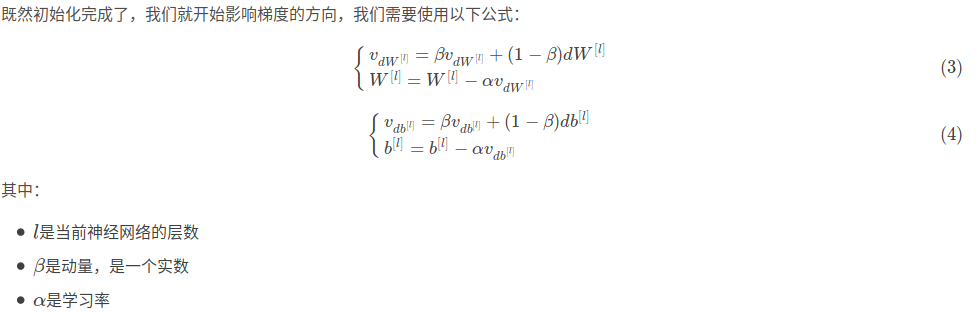

In [8]:
def update_params_with_momentum(params, grads, v, beta, learning_rate):
    """
    param:
    params:包含W和b的字典
    grads:包含dW和db的字典
    v:包含vdW和vdb的字典
    beta:动量
    learning_rate:学习率
    
    return:
    params:W和b的字典
    v:更新后的vdW和vdb
    """
    L = len(params) // 2
    
    for i in range(L):
        v["dW" + str(i + 1)] = beta * v["dW" + str(i + 1)] + (1 - beta) * grads["dW" + str(i + 1)]
        v["db" + str(i + 1)] = beta * v["db" + str(i + 1)] + (1 - beta) * grads["db" + str(i + 1)]
        
        params["W" + str(i + 1)] = params["W" + str(i + 1)] - learning_rate * v["dW" + str(i + 1)]
        params["b" + str(i + 1)] = params["b" + str(i + 1)] - learning_rate * v["db" + str(i + 1)]
    
    return params, v

In [9]:
#测试动量梯度更新
params, grads, v = testCase.update_parameters_with_momentum_test_case()
params, v = update_params_with_momentum(params, grads, v, beta = 0.9, learning_rate = 0.01)
print(params)
print(v)

{'W1': array([[ 1.62544598, -0.61290114, -0.52907334],
       [-1.07347112,  0.86450677, -2.30085497]]), 'b1': array([[ 1.74493465],
       [-0.76027113]]), 'W2': array([[ 0.31930698, -0.24990073,  1.4627996 ],
       [-2.05974396, -0.32173003, -0.38320915],
       [ 1.13444069, -1.0998786 , -0.1713109 ]]), 'b2': array([[-0.87809283],
       [ 0.04055394],
       [ 0.58207317]])}
{'dW1': array([[-0.11006192,  0.11447237,  0.09015907],
       [ 0.05024943,  0.09008559, -0.06837279]]), 'dW2': array([[-0.02678881,  0.05303555, -0.06916608],
       [-0.03967535, -0.06871727, -0.08452056],
       [-0.06712461, -0.00126646, -0.11173103]]), 'db1': array([[-0.01228902],
       [-0.09357694]]), 'db2': array([[0.02344157],
       [0.16598022],
       [0.07420442]])}


速度v在初始化中全为0，因此算法需要经过几次迭代之后才能提升v进而跨越更大的步长。           
当β = 0时，该算法相当于无momentum的标准梯度下降。     
β越大，则平滑作用越明显。     
那么如何才能够在一开始就以较快的速度进行梯度下降，而不用momentum的预热呢，我们可以使用Adam算法。

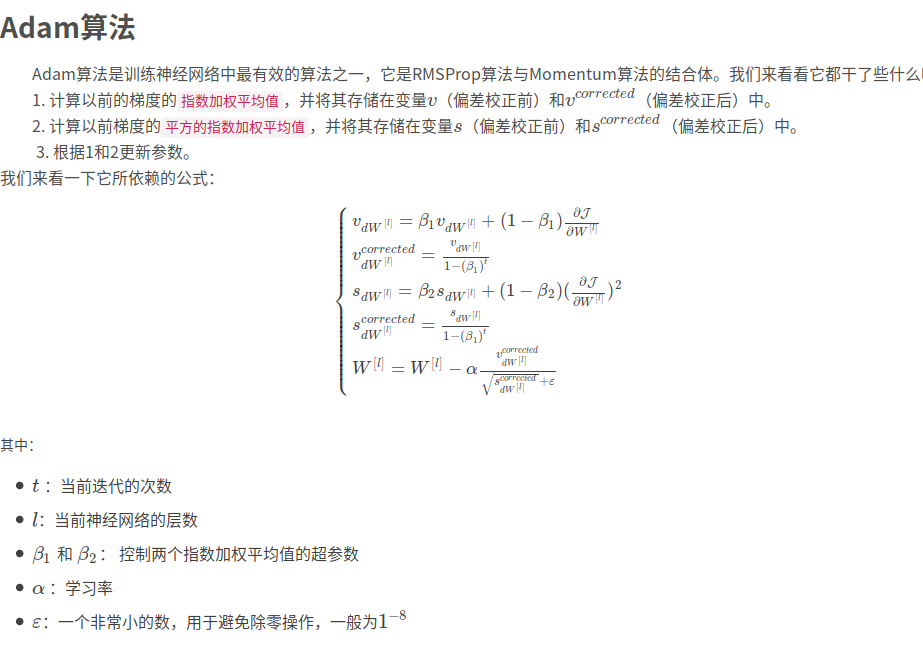

In [10]:
#定义Adam算法初始化
def init_Adam(params):
    '''
    param:
    params:包含W和b的字典
    
    return:
    v:指数加权平均vdW和vdb的字典
    s:平方指数加权平均sdW和sdb的字典
    '''
    L = len(params) // 2
    v = {}
    s = {}
    
    for i in range(L):
        v["dW" + str(i + 1)] = np.zeros_like(params["W" + str(i + 1)])
        v["db" + str(i + 1)] = np.zeros_like(params["b" + str(i + 1)])
        
        s["dW" + str(i + 1)] = np.zeros_like(params["W" + str(i + 1)])
        s["db" + str(i + 1)] = np.zeros_like(params["b" + str(i + 1)])
    
    return (v, s)      

In [11]:
#测试init_Adam
params = testCase.initialize_adam_test_case()
v, s = init_Adam(params)
print(v)
print(s)

{'dW1': array([[0., 0., 0.],
       [0., 0., 0.]]), 'db1': array([[0.],
       [0.]]), 'dW2': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'db2': array([[0.],
       [0.],
       [0.]])}
{'dW1': array([[0., 0., 0.],
       [0., 0., 0.]]), 'db1': array([[0.],
       [0.]]), 'dW2': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'db2': array([[0.],
       [0.],
       [0.]])}


In [12]:
#定义Adam参数更新
def update_params_with_Adam(params, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    """
    param:
    params:W和b的字典
    grads:dW和db的字典
    v:vdW和vdb的字典
    s:sdW和sdb的字典
    t:当前迭代的次数
    learning_rate:学习率
    beta1:momentum的超参数
    beta2:RMSprop的超参数
    epsilon:防止分母为0
    
    return:
    params:更新后的W和b
    v:momentum的参数vdW和vdb
    s:RMSprop的参数sdW和sdb
    """
    L = len(params) // 2
    v_corrected = {}
    s_corrected = {}
    
    for i in range(L):
        #momentum的梯度移动平均值
        v["dW" + str(i + 1)] = beta1 * v["dW" + str(i + 1)] + (1 - beta1) * grads["dW" + str(i + 1)]
        v["db" + str(i + 1)] = beta1 * v["db" + str(i + 1)] + (1 - beta1) * grads["db" + str(i + 1)]
        #momentum修正后的估计值
        v_corrected["dW" + str(i + 1)] = v["dW" + str(i + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(i + 1)] = v["db" + str(i + 1)] / (1 - np.power(beta1, t))
        
        #RMSprop的梯度平方移动均值
        s["dW" + str(i + 1)] = beta2 * s["dW" + str(i + 1)] + (1 - beta2) * np.square(grads["dW" + str(i + 1)])
        s["db" + str(i + 1)] = beta2 * s["db" + str(i + 1)] + (1 - beta2) * np.square(grads["db" + str(i + 1)])
        #RMSprop修正后的估计值
        s_corrected["dW" + str(i + 1)] = s["dW" + str(i + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(i + 1)] = s["db" + str(i + 1)] / (1 - np.power(beta2, t))
        
        #更新W和b
        params["W" + str(i + 1)] = params["W" + str(i + 1)] - learning_rate * (v_corrected["dW" + str(i + 1)] / np.sqrt
                                                                              (s_corrected["dW" + str(i + 1)] + epsilon))
        params["b" + str(i + 1)] = params["b" + str(i + 1)] - learning_rate * (v_corrected["db" + str(i + 1)] / np.sqrt
                                                                              (s_corrected["db" + str(i + 1)] + epsilon))
    
    return (params,v,s)

In [13]:
#测试Adam参数更新
params, grads, v, s = testCase.update_parameters_with_adam_test_case()
update_params_with_Adam(params, grads, v, s, t = 2)
print(params)
print(v)
print(s)

{'W1': array([[ 1.63178673, -0.61919778, -0.53561312],
       [-1.08040999,  0.85796626, -2.29409733]]), 'b1': array([[ 1.75225313],
       [-0.75376553]]), 'W2': array([[ 0.32648046, -0.25681174,  1.46954931],
       [-2.05269934, -0.31497584, -0.37661299],
       [ 1.14121081, -1.09245036, -0.16498684]]), 'b2': array([[-0.88529978],
       [ 0.03477238],
       [ 0.57537385]])}
{'dW1': array([[-0.11006192,  0.11447237,  0.09015907],
       [ 0.05024943,  0.09008559, -0.06837279]]), 'dW2': array([[-0.02678881,  0.05303555, -0.06916608],
       [-0.03967535, -0.06871727, -0.08452056],
       [-0.06712461, -0.00126646, -0.11173103]]), 'db1': array([[-0.01228902],
       [-0.09357694]]), 'db2': array([[0.02344157],
       [0.16598022],
       [0.07420442]])}
{'dW1': array([[0.00121136, 0.00131039, 0.00081287],
       [0.0002525 , 0.00081154, 0.00046748]]), 'dW2': array([[7.17640232e-05, 2.81276921e-04, 4.78394595e-04],
       [1.57413361e-04, 4.72206320e-04, 7.14372576e-04],
       [4.50

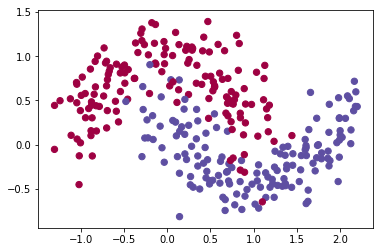

In [14]:
train_X, train_Y = opt_utils.load_dataset(is_plot = True)

In [15]:
def model(X, Y, layer_dims, optimizer, learning_rate = 0.0007, batch_size = 64, beta = 0.9, beta1 = 0.9, beta2 = 0.999,
         epsilon = 1e-8, num_iterations = 10000, print_cost = True, is_Plot = True):
    """
    param:
    X:输入数据
    Y:输入标签
    layer_dims:NN层数和每层单元的数量
    optimizer:[GD|momentum|Adam]
    learning_rate:学习率
    batch_size:miniBatch的大小
    beta:momentum的超参数
    beta1:Adam的超参数1，相当于momentum的超参数
    beta2:Adam的超参数2，相当于RMSprop的超参数
    epsilon:Adam中避免分母为0的超参数
    num_iterations:迭代次数
    print_cost:是否打印误差，每1000次
    is_Plot:是否画图
    
    return:
    params:包含新的W和b的字典
    """
    L = len(layer_dims)
    costs = []
    t = 0#每学习完一个minibatch后+1
    seed = 10#随机数种子
    
    #初始化参数
    params = opt_utils.initialize_parameters(layer_dims)
    
    #选择优化器
    if optimizer == "GD":
        pass #不使用优化方式，直接采用梯度下降
    elif optimizer == "momentum":
        v = init_v(params)
    elif optimizer == "Adam":
        v, s = init_Adam(params)
    else:
        print("Optimizer Error!")
        exit(1)
        
    #开始学习
    for i in range(num_iterations):
        seed = seed + 1#每次重新对数据集洗牌
        mini_batches = random_mini_batches(X, Y, batch_size, seed)
        
        for mini_batch in mini_batches:
            (mini_batch_X, mini_batch_Y) = mini_batch
            #前向传播
            A3, cache = opt_utils.forward_propagation(mini_batch_X, params)
            #计算误差
            cost = opt_utils.compute_cost(A3, mini_batch_Y)
            #反向传播
            grads = opt_utils.backward_propagation(mini_batch_X, mini_batch_Y, cache)
            
            #更新参数
            if optimizer == "GD":
                params = update_params_with_GradientDescent(params, grads, learning_rate)
            elif optimizer == "momentum":
                params, v = update_params_with_momentum(params, grads, v, beta, learning_rate)
            elif optimizer == "Adam":
                t = t + 1
                params, v, s = update_params_with_Adam(params, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost and i % 1000 == 0:
                print("第" + str(i) + "次遍历整个数据集，当前误差为：" + str(cost))
    
    if is_Plot:
        plt.plot(costs)
        plt.xlabel("iteration")
        plt.ylabel("cost")
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return params

第0次遍历整个数据集，当前误差为：0.690735512291113
第1000次遍历整个数据集，当前误差为：0.6852725328458241
第2000次遍历整个数据集，当前误差为：0.6470722240719003
第3000次遍历整个数据集，当前误差为：0.6195245549970403
第4000次遍历整个数据集，当前误差为：0.5765844355950944
第5000次遍历整个数据集，当前误差为：0.6072426395968576
第6000次遍历整个数据集，当前误差为：0.5294033317684576
第7000次遍历整个数据集，当前误差为：0.46076823985930115
第8000次遍历整个数据集，当前误差为：0.465586082399045
第9000次遍历整个数据集，当前误差为：0.46451797221676844


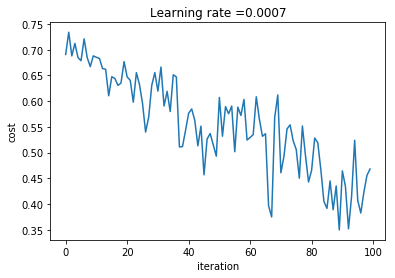

In [16]:
layer_dims = [train_X.shape[0], 5, 2, 1]
params = model(train_X, train_Y, layer_dims, optimizer = "GD")

Accuracy: 0.7966666666666666


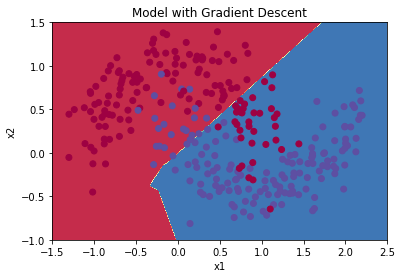

In [17]:
pred = opt_utils.predict(train_X, train_Y, params)
plt.title("Model with Gradient Descent")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
train_Y = np.squeeze(train_Y)
opt_utils.plot_decision_boundary(lambda x : opt_utils.predict_dec(params, x.T), train_X, train_Y)

第0次遍历整个数据集，当前误差为：0.6907412988351506
第1000次遍历整个数据集，当前误差为：0.6853405261267578
第2000次遍历整个数据集，当前误差为：0.6471448370095255
第3000次遍历整个数据集，当前误差为：0.6195943032076022
第4000次遍历整个数据集，当前误差为：0.5766650344073023
第5000次遍历整个数据集，当前误差为：0.607323821900647
第6000次遍历整个数据集，当前误差为：0.5294761758786997
第7000次遍历整个数据集，当前误差为：0.46093619004872366
第8000次遍历整个数据集，当前误差为：0.465780093701272
第9000次遍历整个数据集，当前误差为：0.4647395967922748


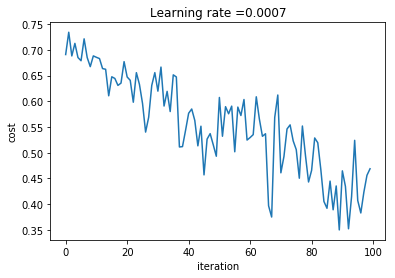

In [18]:
layer_dims = [train_X.shape[0], 5, 2, 1]
train_Y = train_Y.reshape(1, train_Y.shape[0])
params = model(train_X, train_Y, layer_dims, optimizer = "momentum")

Accuracy: 0.7966666666666666


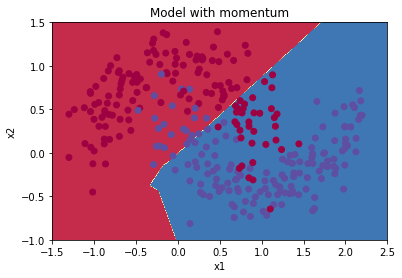

In [19]:
pred = opt_utils.predict(train_X, train_Y, params)
plt.title("Model with momentum")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
train_Y = np.squeeze(train_Y)
opt_utils.plot_decision_boundary(lambda x : opt_utils.predict_dec(params, x.T), train_X, train_Y)

第0次遍历整个数据集，当前误差为：0.6905522446113365
第1000次遍历整个数据集，当前误差为：0.18550136438550574
第2000次遍历整个数据集，当前误差为：0.15083046575253203
第3000次遍历整个数据集，当前误差为：0.0744543857099718
第4000次遍历整个数据集，当前误差为：0.1259591565133716
第5000次遍历整个数据集，当前误差为：0.10434443534245479
第6000次遍历整个数据集，当前误差为：0.10067637504120665
第7000次遍历整个数据集，当前误差为：0.031652030135115576
第8000次遍历整个数据集，当前误差为：0.111972731312442
第9000次遍历整个数据集，当前误差为：0.19794007152465484


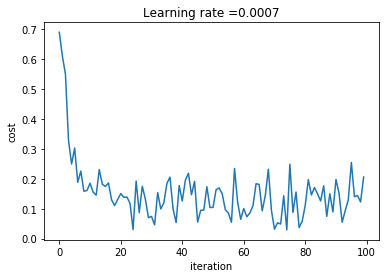

In [20]:
layer_dims = [train_X.shape[0], 5, 2, 1]
train_Y = train_Y.reshape(1, train_Y.shape[0])
params = model(train_X, train_Y, layer_dims, optimizer = "Adam")

Accuracy: 0.94


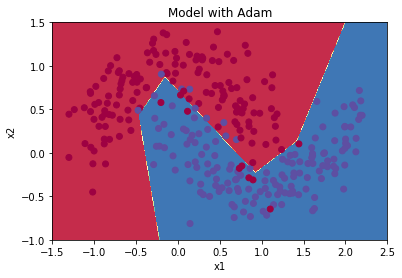

In [21]:
pred = opt_utils.predict(train_X, train_Y, params)
plt.title("Model with Adam")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
train_Y = np.squeeze(train_Y)
opt_utils.plot_decision_boundary(lambda x : opt_utils.predict_dec(params, x.T), train_X, train_Y)

对比普通的梯度下降GD、动量梯度下降法momentum、Adam三种方法可知：        
1.GD和momentum的准确率accuracy都为0.797，Adam的准确率为0.94。这说明在相同的迭代次数即时间花费下，Adam的收敛速度最快，对算法的效率有明显提升。        
2.GD和momentum相对于Adam有明显的预热过程，即不会在刚开始突然加快梯度下降速度，而是会慢慢迭代。而Adam在第1000次迭代的时候就已经快要收敛。   
3.通常来说momentum也具备很好的效果，但是本实验的点集很小且迭代次数不够多，所以无法体现momentum对普通梯度下降的优势。   
4.GD和momentnum的迭代震荡幅度要高于Adam，Adam的收敛范围更小更平滑。